# Importing the libraries

In [539]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [540]:
import torch
from pathlib import Path
import gzip, pickle
from torch import nn
from torch import tensor
from torch.utils.data import DataLoader
from torch import optim
import requests
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
import copy
from math import ceil
sns.set()

In [541]:
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = 'normal'

In [542]:
MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
MODEL_STATE_DICT_PATH = 'stage-1.pth'
BATCH_SIZE = 64

# Helper Methods 

## Method to download data

In [543]:
def download_data(url):
    """
    Downloads the data file from the url
    
    Args:
        url (String): Url of the data file to be downloaded
        
    Returns:
        The path to the file
    """
    cwd= Path(os.getcwd())
    file_name = url.split('/')[-1]
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)
    return cwd/file_name

## Method to load data from file 

In [544]:
def get_data(path):
    """
    Loads the data from the file system into Pytorch tensors
    
    Args: 
        path (pathlib.Path): Path to the file
        
    Returns:
        Pytorch tensors for X_train, y_train, X_valid, y_valid, X_test, y_test
    """
    with gzip.open(path) as file:
        ((X_train,y_train),(X_valid, y_valid),(X_test,y_test)) = pickle.load(file, encoding='latin-1')
        return map(tensor, (X_train,y_train, X_valid, y_valid, X_test, y_test))

## Dataset Class

In [545]:
class Dataset():
    """
    Stores the X and y variables together as a Dataset
    
    Example usage:
        train_ds = Dataset(X_train,y_train)
        X,y = train_ds[:10]
        
        Here the train_ds will return the first 10 elements of both X_train and y_train
        
    """
    def __init__(self, X, y):
        """
        To initialize the Dataset Class.
        
        Args:
            X (torch.tensor): Data
            y (torch.tensor): Label for data
            
        """
        self.X, self.y = X, y
        
    def __len__(self):
        """
        Allows the usage of len() functions
        
        Returns:
            length of X
        """
        return len(self.X)
    
    def __getitem__(self,idx):
        """
        Allows the usage of indexing on the Dataset
        
        Args:
            idx : list style index        
            
        Returns: 
            elements at the index 'idx' for both X and y
            
        """
        return self.X[idx],self.y[idx]

## Method to prepare the DataLoaders for train and validation data

In [546]:
def get_dls():
    """
    Creates DataLoaders for training and validation data.
    
    Returns:
        Training Dataloader, Validation DataLoader
    """
    return (DataLoader(Dataset(X_train,y_train), batch_size=BATCH_SIZE,shuffle=True,drop_last=True),
           DataLoader(Dataset(X_valid,y_valid), batch_size=BATCH_SIZE,shuffle=False))

## Method to get the model and the optimizer

In [555]:
def get_model(pct_sparsity=0.,use_gpu=True):
    """
    Creates a Pytorch nn.Sequential Model with the specified layers and a SGD optimizer.
    
    Args: 
        use_gpu: (boolean) If True loads the model on the GPU. If False, uses CPU
        
    Returns:
        Model and optimizer
    """
    pct_units = round(1 - pct_sparsity,2)
    model = nn.Sequential(nn.Linear(784,int(1000*pct_units),bias=False),
                          nn.ReLU(),
                          nn.Linear(int(1000*pct_units),int(1000*pct_units),bias=False),
                          nn.ReLU(),
                          nn.Linear(int(1000*pct_units),int(500*pct_units),bias=False),
                          nn.ReLU(),
                          nn.Linear(int(500*pct_units),int(200*pct_units),bias=False),
                          nn.ReLU(),
                          nn.Linear(int(200*pct_units),10,bias=False)
                         )
    
    if use_gpu:
        return model.cuda()
    
    return model
    

def get_optimizer(model,lr=0.1):
    """
    Creates SGD optimizer with the model parameters and learning rate
    
    Args:
        model : nn.Module model 
        lr (float): learning rate for the optimizer
        
    Returns: 
        returns an optimizer
    """
    
    return optim.SGD(model.parameters(), lr=lr)

# Method to calculate accuracy

In [556]:
def accuracy(preds, y): 
    """ Calculates the accuracy of input batch """
    return (torch.argmax(preds,dim=1) == y).float().mean()

## Average Metrics (Weighted average)

In [557]:
def average_metrics(dataloader,model,metrics=[],use_gpu=True):
    """
    Calculates the weighted average metrics, weighted by the batch size.
    This ensures the correctness of the average metrics calculated even if the batch size changes
    
    Args: 
        dataloader (DataLoader) : DataLoader for the required dataset. Preferably the validation set.
        metrics (list) : A list of metrics. Each metric passed in the list should be a function.
        use_gpu: (boolean) If True loads the data batch on the GPU. If False, keeps the data batch on CPU

    Returns:
        List of average metrics in the order passed in the metrics list.
        
    """
    with torch.no_grad():
        count = 0
        tot_metrics = [0. for _ in metrics]
        for xb,yb in dataloader:
            if use_gpu:
                xb, yb = xb.cuda(), yb.cuda()
                
            bs=len(xb)
            for idx, metric in enumerate(metrics):
                tot_metrics[idx] += metric(model(xb),yb) * bs  # metric * batch_size for weighted average

            count += bs

        avg_metrics = list()
        for metric in tot_metrics:
            avg_metrics.append(metric/count)

        return avg_metrics
        

## Fit function

In [558]:
def fit(epochs,use_gpu=True):
    """
    The fit function contains the training loop. Prints the validation accuracy and validation loss
    
    Args: 
        epochs: Number of epochs to fit
        use_gpu: (boolean) If True loads the data batch on the GPU. If False, keeps the data batch on CPU
    
    """
    for epoch in range(epochs):       # for each epoch
        for xb,yb in train_dl:        # for each batch in the train_dl
            if use_gpu:
                xb, yb = xb.cuda(), yb.cuda()
            preds = model(xb)  # predictions are calculated in the forward pass
            loss = loss_func(preds,yb)  # loss is calculated
            loss.backward()           # the gradients are accumulated
            opt.step()                # weights are updated by 'lr * gradients'
            opt.zero_grad()           # gradients are set to zeros
        with torch.no_grad():
            print(average_metrics(valid_dl,model,[accuracy,loss_func],use_gpu))

# Loading the data

In [559]:
path = download_data(MNIST_URL)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_data(path)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# Model, Optimizer, Loss function and Dataloaders

In [560]:
loss_func = nn.CrossEntropyLoss()
train_dl, valid_dl = get_dls()
model = get_model()
opt = get_optimizer(model)
model, opt

(Sequential(
   (0): Linear(in_features=784, out_features=1000, bias=False)
   (1): ReLU()
   (2): Linear(in_features=1000, out_features=1000, bias=False)
   (3): ReLU()
   (4): Linear(in_features=1000, out_features=500, bias=False)
   (5): ReLU()
   (6): Linear(in_features=500, out_features=200, bias=False)
   (7): ReLU()
   (8): Linear(in_features=200, out_features=10, bias=False)
 ), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.1
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

# Fitting the model

In [561]:
fit(4)

[tensor(0.9419, device='cuda:0'), tensor(0.1947, device='cuda:0')]
[tensor(0.9621, device='cuda:0'), tensor(0.1267, device='cuda:0')]
[tensor(0.9683, device='cuda:0'), tensor(0.1041, device='cuda:0')]
[tensor(0.9740, device='cuda:0'), tensor(0.0887, device='cuda:0')]


#  Save the state_dict

In [562]:
torch.save(model.state_dict(),MODEL_STATE_DICT_PATH)

In [563]:
class Learner():
    def __init__(self, model,train_dl, valid_dl):
        self.model, self.train_dl, self.valid_dl = model, train_dl, valid_dl

# Pruning

Now that we have fit the model, we have got a reasonable accuracy to start with. We can no start with pruning the weights of the network. 

Given a layer of a neural network ReLU are two well-known ways to prune it:

**Weight pruning** : 
* Set individual weights in the weight matrix to zero. This corresponds to deleting connections.
* Here, to achieve sparsity of k% we rank the individual weights in weight matrix W according to their magnitude (absolute value), and then set to zero the smallest k%.

**Unit/Neuron pruning** : 
* Set entire columns to zero in the weight matrix, in effect deleting the corresponding output neuron.
* Here to achieve sparsity of k% we rank the columns of a weight matrix according to their L2-norm and delete the smallest k%.

In [564]:
class Pruner():
    """ 
    Base Class for Pruning   
    
    """
    
    def __init__(self, k_list,state_dict,learner,metrics=[],save_weights=False,use_gpu=True):
        
        """ 
        Inits the Pruner Class
        
        
        Args: 
        
        k_list : List of k's for pruning k% of weights or units
        state_dict : State dictionary of trained model
        metrics : list of metrics to calculate

        """
        self.k_list, self.state_dict, self.learner, self.save_weights, self.use_gpu = k_list, state_dict, learner, save_weights, use_gpu
        self.orig_metrics = list()
        self.metrics = list()
        self.metrics_dict = dict()
        for name,metric in metrics:
            self.metrics_dict[name] =list()
            self.metrics.append(metric)
            
    def prune(self):
        """ 
        Base for pruning. The logic is to load the weights from the state_dictionary, go through each layer(not the activation layers),
        call the _prune function, get the pruned weights and update the weights of the layer with the pruned weights.
        Also calculates and stores the accuracy and loss for each value of k in k_list

        """
        with torch.no_grad():
            model = self._get_model()
            self.orig_metrics = average_metrics(self.learner.valid_dl, model, self.metrics,self.use_gpu)
            
            for k in self.k_list:
                model_ = copy.deepcopy(model)
                model_.load_state_dict(self.state_dict)  # load state from state
                
                layers = [ _ for _ in model_ if hasattr(_,'weight')]
                for idx,layer in enumerate(layers[:-1]):
                    pruned_weights = self._prune(layer,k)
                    pruned_weights = pruned_weights.cuda() if self.use_gpu else pruned_weights
                    layers[idx].weight = nn.Parameter(pruned_weights)
                
                layers = self._update_final_layer(layers)
                self._save_weights(model_,k)
                self._calculate_metrics(model_)
                
                
    def _prune(self, layer, k):
        """
        Method to be implemented by the subclass
        """
        raise NotImplementedError
    
    def _update_final_layer(self, layers):
        """
        Implementationt to Update the final layer of the model
        """
        return layers
    
    def _save_weights(self, model,k):
        """
        Saves the model is self.save_weights is True
        """
        if self.save_weights: 
            torch.save(model.state_dict(),f'{self.type}{"sparse" if hasattr(self,"sparse") and self.sparse else ""}_sparsity_{k}.pth')
        
    def _calculate_metrics(self,model):
        """
        Saves the average metrics to the corresponding list
        """
        metrics = average_metrics(self.learner.valid_dl, model, self.metrics, self.use_gpu)

        for idx,(metric_name,_) in enumerate(list(self.metrics_dict.items())):
            self.metrics_dict[metric_name].append(metrics[idx])
                    
    def _get_model(self):
        model= self.learner.model
        model.load_state_dict(self.state_dict)
        return model

## Implementation for Weight Pruning

In [565]:
class WeightPruner(Pruner):
    """
    Weight Pruning: 
        Implements _prune method for weight pruning, where the smallest k% of the weights will be set to zero.   
    
    """
        
    def __init__(self, k_list,state_dict,learner, metrics=[],save_weights=False,use_gpu=True):
        """
        Inits the UnitPruner
        
        Args:
            k_list : List of k's for pruning k% of weights or units
            state_dict : State dictionary of trained model
            metrics : list of metrics to calculate
            save_weights (boolean) : sets the save_weights flag. If True, save the file to disk with name 'sparsity-'
        """
        super().__init__(k_list,state_dict,learner, metrics=metrics,save_weights=save_weights,use_gpu=use_gpu)
        self.type = 'weight'
        
    def _prune(self,layer,k):
        """
        Core implementation of weight pruning. The logic is to get the weights of the passed layer, flatten the weight matrix, 
        get the absolute values, sort them, and get the indices of the first k% of the sorted values and set them to zero.
        
        Args:
            layer: layer of the model being pruned
            k : percentage of pruning to be performed
            
        Returns:
            pruned weights is returned
            
        """
        weights = layer.weight
        if k > 0:
            flat = weights.view(-1)
            sorted_weights = self._sort(flat)
            k_position = int(0.01*k*len(flat))
            flat = self._update_weights(flat, sorted_weights[1], k_position)
        
        return weights
    
    def _sort(self,weights):
        """ Sort implementation for weight pruning """
        return weights.abs().sort()
    
    def _update_weights(self, weights, indices, k_position):
        weights[indices[:k_position]] = 0.
        return weights
    

## Implementation for Unit Pruning

In [566]:
class UnitPruner(Pruner):
    """
    Unit/ Neuron pruning: 
        Implements _prune method for unit/neuron pruning, where the neurons with smallest k% L2 norm of the weights will be set to zero.
                    
    """
    
    def __init__(self, k_list, state_dict,learner, metrics=[], save_weights=False,sparse=False,use_gpu=True):
        """
        Inits the UnitPruner
        
        Args:
            k_list : List of k's for pruning k% of weights or units
            state_dict : State dictionary of trained model
            metrics : list of metrics to calculate
            
        """
        super().__init__(k_list, state_dict,learner ,metrics=metrics, save_weights=save_weights, use_gpu=use_gpu)
        self.type = 'unit'
        self.units_kept = None
        self.sparse = sparse
        
    def _prune(self, layer, k):
        """
        Core implementation of unit/ neuron pruning. The logic is to get the weights of the passed layer, get the l2 norm of the weights
        across the dim = 1, i.e. for each neuron, then sort the l2 norms,  get the indices of the first k% of the sorted values and set them to zero
        
        Args:
            layer: layer of the model being pruned
            k : percentage of pruning to be performed
            
        Returns:
            pruned weights is returned
        
        """
        weights = layer.weight
        if k > 0:
            sorted_weights = self._sort(weights)
            k_position= int(0.01*k*len(sorted_weights[0]))
            weights = self._update_connections(weights)
            weights = self._update_weights(weights, sorted_weights[1], k_position)  # update the weights
           
        return weights
    
    def _sort(self,weights):
        """
        Sort implementation for unit pruning 
        
        Args: 
            weights: weight matrix
        
        Return: 
            returns the tuple of sorted tensor and tensor of indices
        
        """
        
        return weights.pow(2).sum(dim=1).sqrt().sort()
    
    def _update_connections(self, weights):
        """
        Deletes the previous layer's neuron's connection entries in the weight matrix of the current layer. 
        Checks if the units_kept is not None. If not None, it means that the current layer is not the first layer, deletes the corresponding entry from the current layer. 
        
        Args: 
            weights: weight matrix
        
        Returns:
            returns the updated weights
        
        """
        if self.units_kept is not None:
            return weights[:,self.units_kept]
        return weights
                
    def _update_weights(self, weights, sorted_indices, k_position):
        """
        Updates the weights based on the prune logic. Also has the implementation for the sparse version. 
        Sparse version deletes the units where as the non sparse version
        """
        if self.sparse:
            indices = sorted_indices[k_position:].sort()[0]  # gets the indices of the units to be kept and sorts it
            weights = weights[indices]  # updates the weights
            self.units_kept = indices  # self the units kept
        
        else:
            weights[sorted_indices[:k_position]] = 0.
            
        return weights
    
    def _update_final_layer(self,layers):
        if self.type == 'unit' and self.units_kept is not None:
            layers[-1].weight = nn.Parameter(layers[-1].weight[:,self.units_kept])
            self.units_kept = None
        return layers

In [567]:
def plot_accuracies(pruner):
    """
    Plots the accuracies for each k value of the pruner. Also plots the original accuracy with no pruning.
    
    Args: 
        pruner : Object of type Pruner
        
    """
    plt.figure(figsize=(10,8))
    plt.plot(pruner.k_list,pruner.metrics_dict['accuracy'],color='red',marker='o')
    plt.plot(pruner.k_list,[pruner.orig_metrics[0]]*len(pruner.k_list),color='blue',marker='o')
#     plt.xticks(pruner.k_list,rotation='90')
    for k,metric in zip(pruner.k_list,pruner.metrics_dict['accuracy']):
        label = "{:.4f}".format(metric)
        plt.annotate(label,
                     (k,metric),
                     textcoords="offset points",
                     xytext=(10,10),
                     ha='center')
    plt.xlabel('Percent Sparsity')
    plt.ylabel('Percent Accuracy')
    plt.title(f'Effect of {pruner.type} pruning on accuracy')
    plt.show()


In [568]:
def plot_losses(pruner):
    """
    Plots the loss for each k value for the pruner. Also plots the original loss with no pruning.
    
    Args: 
        pruner : Object of type Pruner
        
    """
    plt.figure(figsize=(10,8))
    plt.plot(pruner.k_list,pruner.metrics_dict['loss'],color='red',marker='o')
    plt.plot(pruner.k_list,[pruner.orig_metrics[1]]*len(pruner.k_list),color='blue',marker='o')
#     plt.xticks(k_list,rotation=90)
    for k,metric in zip(pruner.k_list,pruner.metrics_dict['loss']):
        label = "{:.4f}".format(metric)
        plt.annotate(label,
                     (k,metric),
                     textcoords="offset points",
                     xytext=(10,10),
                     ha='center')
    plt.xlabel('Percent Sparsity')
    plt.ylabel('Percent Loss')
    plt.title(f'Effect of {pruner.type} pruning on loss')
    plt.show()

In [580]:
def run_pruning(pruner):
    pruner.prune()
    plot_accuracies(pruner)

#### The list of k's as specified in the challenge description

In [581]:
k_list = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
metrics = [('accuracy',accuracy), ('loss',loss_func)]

In [582]:
learner = Learner(get_model(),train_dl, valid_dl)

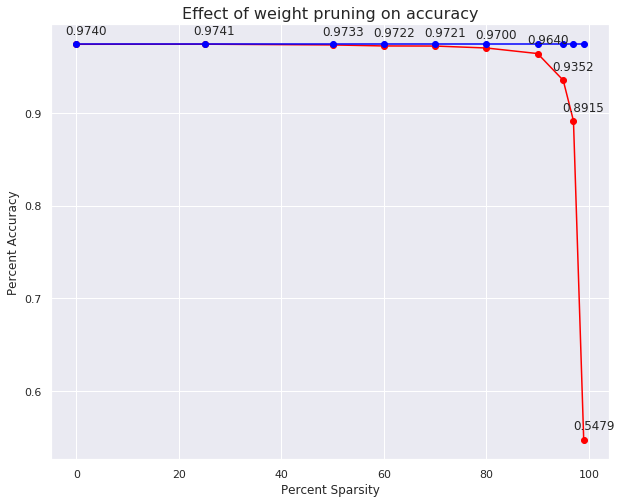

CPU times: user 3.67 s, sys: 174 ms, total: 3.84 s
Wall time: 4.09 s


In [583]:
%%time
run_pruning(WeightPruner(k_list, torch.load(MODEL_STATE_DICT_PATH),learner,metrics,save_weights=True,use_gpu=True))

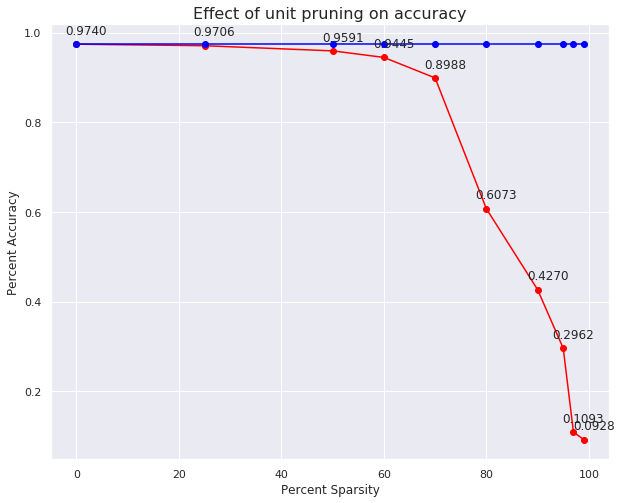

CPU times: user 3.97 s, sys: 178 ms, total: 4.15 s
Wall time: 4.73 s


In [584]:
%%time
run_pruning(UnitPruner(k_list,torch.load(MODEL_STATE_DICT_PATH),learner,metrics,save_weights=True))

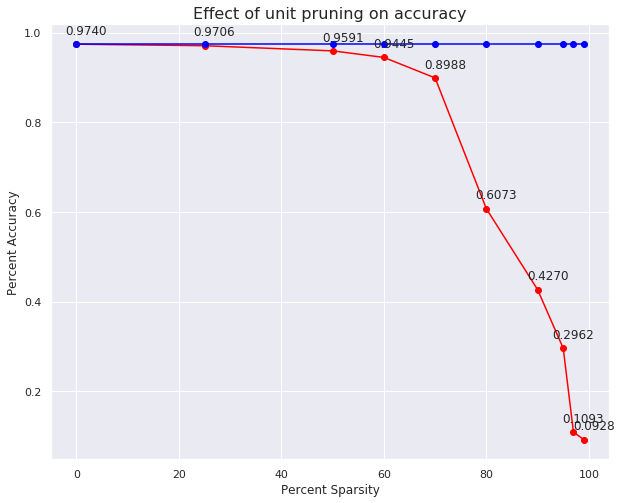

CPU times: user 3.69 s, sys: 105 ms, total: 3.8 s
Wall time: 3.87 s


In [585]:
%%time
run_pruning(UnitPruner(k_list,torch.load(MODEL_STATE_DICT_PATH),learner,metrics,save_weights=True,sparse=True))

# Model Speed Experiment

In [575]:
model = get_model(pct_sparsity=0.5, use_gpu=False)
model.load_state_dict(torch.load('unitsparse_sparsity_50.pth'))

Time for running 50% sparsity

In [467]:
%%timeit -n 10
model(valid_dl.dataset.X)

142 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [433]:
model = get_model(pct_sparsity=0.6,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_60.pth"))

Time for running 60% sparsity

In [434]:
%%timeit -n 10
model(valid_dl.dataset.X)

91.5 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [435]:
model = get_model(pct_sparsity=0.7,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_70.pth"))

Time for running 70% sparsity

In [436]:
%%timeit -n 10
model(valid_dl.dataset.X)

65.5 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [437]:
model = get_model(pct_sparsity=0.8,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_80.pth"))

Time for running 80% sparsity

In [438]:
%%timeit -n 10
model(valid_dl.dataset.X)

39.7 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [439]:
model = get_model(pct_sparsity=0.9,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_90.pth"))

Time for running 90% sparsity

In [440]:
%%timeit -n 10
model(valid_dl.dataset.X)

25.5 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [441]:
model = get_model(pct_sparsity=0.95,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_95.pth"))

Time for running 95% sparsity

In [442]:
%%timeit -n 10
model(valid_dl.dataset.X)

8.41 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [443]:
model = get_model(pct_sparsity=0.97,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_97.pth"))

Time for running 97% sparsity

In [444]:
%%timeit -n 10
model(valid_dl.dataset.X)

5.24 ms ± 544 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [445]:
model = get_model(pct_sparsity=0.99,use_gpu=False)
model.load_state_dict(torch.load("unitsparse_sparsity_99.pth"))

Time for running 99% sparsity

In [446]:
%%timeit -n 10
model(valid_dl.dataset.X)

3.78 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [586]:
model = get_model(use_gpu=False)
model.load_state_dict(torch.load("unit_sparsity_0.pth"))

Time for running 0% sparsity

In [587]:
%%timeit -n 10
model(valid_dl.dataset.X)

361 ms ± 34.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
